In [7]:

'''
Author: Damiano Pasquini
email: damiano23@ru.is
'''

# imports and configs
import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
from joblib import dump
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from seaborn import heatmap

path = './dataset' # Path to the dataset
classifiers = [MultinomialNB(), KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), GradientBoostingClassifier()] # Classifiers to use
warnings.filterwarnings('ignore', category=ConvergenceWarning) # Ignore convergence warnings for Logistic Regression classifier

In [8]:
def read_data(path):
    """
    Reads the data from the csv file and returns a pandas dataframe
    :param path: path to the csv file
    :return: pandas dataframe
    """
    data = [str(line.split(',')) for line in open(path+'/api_trace.csv', 'r')]
    labels = [line for line in open(path+'/apt_trace_labels.txt', 'r')]
    return pd.DataFrame({'traces':data,'labels':labels})

In [9]:
def preprocess(df):
    """
    Preprocess the dataframe and returns the X and y for the training and test set
    :param df: pandas dataframe
    :return: X_train, X_test, y_train, y_test
    """
    df.drop_duplicates(subset=['traces'], inplace=True)
    df.replace([np.inf], np.finfo(np.float32).max, inplace=True)
    df.replace([-np.inf], -np.finfo(np.float32).min, inplace=True)
    df.fillna(0, inplace=True)    
    X_train, X_test, y_train, y_test = train_test_split(df['traces'], df['labels'], test_size=0.3, random_state=42)
    vectorizer = CountVectorizer()
    scaler = MinMaxScaler()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train = scaler.fit_transform(X_train.toarray())
    X_test = scaler.transform(X_test.toarray())
    with open('./vectorizer.joblib', 'wb') as file:
        dump(vectorizer, file)
    with open('./scaler.joblib', 'wb') as file:
        dump(scaler, file)
    return X_train, X_test, y_train, y_test

In [10]:
def train_classifier(X_train, X_test, y_train, y_test, classifier = MultinomialNB()):
    """
    Trains the classifier and prints the heatmap of the confusion matrix
    :param X_train: training set
    :param X_test: test set
    :param y_train: training labels
    :param y_test: test labels
    :param classifier: classifier to use
    :return: None
    """
    clf = classifier
    if classifier == LogisticRegression():
        clf = LogisticRegression(max_iter=1000)
    elif classifier == SVC():
        clf = SVC(random_state=42)
    elif classifier == GradientBoostingClassifier():
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    heatmap(matrix, annot=True)
    f1score = f1_score(y_test, y_pred, average='weighted')
    print('F1 Score: '+str(f1score))
    plt.show()
    return

In [11]:
print('Preprocessing...')
X_train, X_test, y_train, y_test = preprocess(read_data(path))

Preprocessing...


Training classifier:  <class 'sklearn.naive_bayes.MultinomialNB'>
F1 Score: 0.30399494071901517


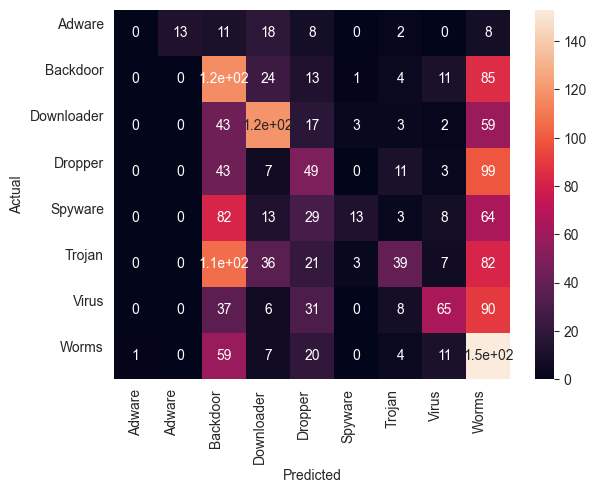

Training classifier:  <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
F1 Score: 0.41395390281195277


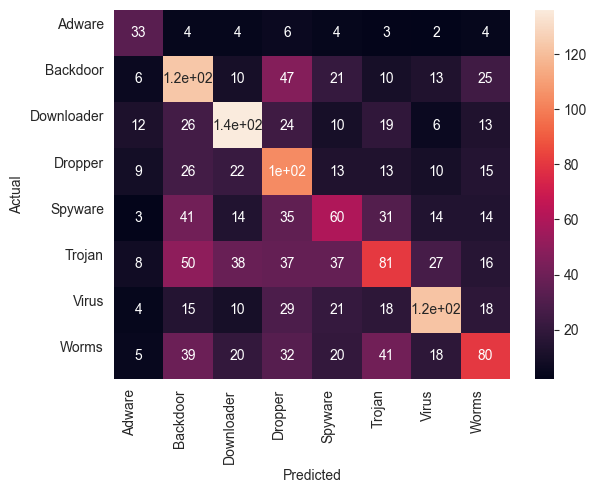

Training classifier:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
F1 Score: 0.2939364863894123


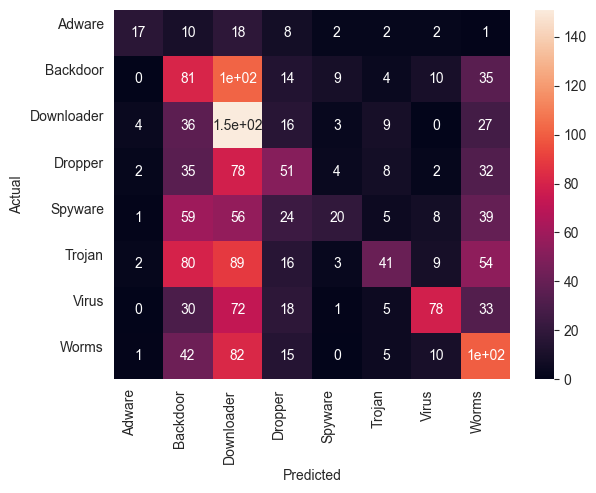

Training classifier:  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
F1 Score: 0.5052116458494808


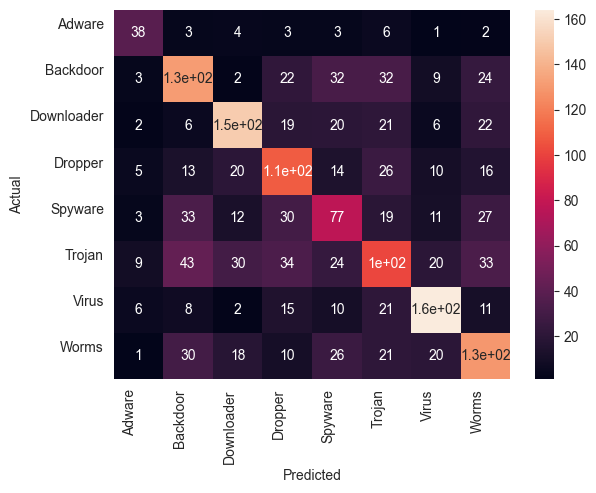

Training classifier:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
F1 Score: 0.6107460479401683


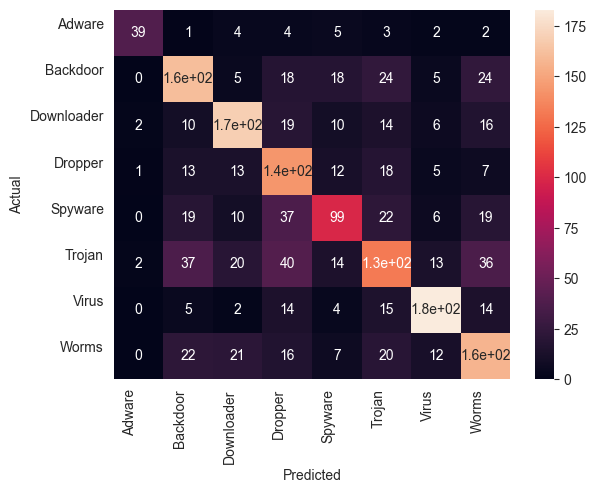

Training classifier:  <class 'sklearn.svm._classes.SVC'>
F1 Score: 0.30706335560623665


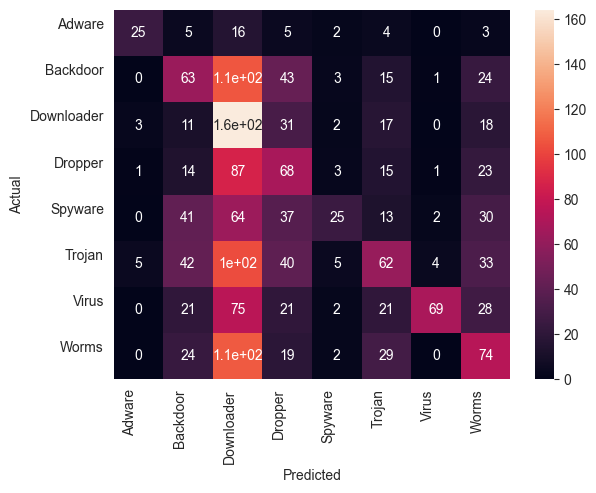

Training classifier:  <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
F1 Score: 0.5727374790104045


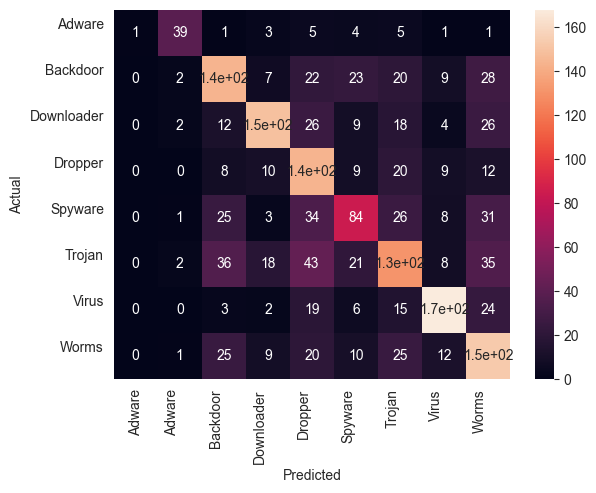

In [12]:
for classifier in classifiers:
    print('Training classifier: ', type(classifier))
    train_classifier(X_train, X_test, y_train, y_test, classifier = classifier)
    if type(classifier) is RandomForestClassifier:
        dump(classifier, './classifier.joblib')